In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/FYP/Toddler Autism dataset July 2018.csv'
df = pd.read_csv(file_path)

In [ ]:
# Convert age from months to years
df['Age'] = df['Age_Mons'] / 12

# Drop unnecessary columns
df = df.drop(
    ['Case_No', 'Age_Mons', 'Sex', 'Ethnicity',
     'Jaundice', 'Family_mem_with_ASD', 'Who completed the test'],
    axis=1
)

# Drop duplicate rows (just in case)
df = df.drop_duplicates()


# (Optional) Check if duplicates are gone
print(f"Duplicates remaining: {df.duplicated().sum()}")

Duplicates remaining: 0


In [ ]:
df['label'] = (df[['Qchat-10-Score']] > 3).astype(int)

In [ ]:
x = df.drop(['Class/ASD Traits ', 'label', 'Qchat-10-Score'], axis=1)
y = df['label']
y.value_counts(normalize=True)


,proportion
label,
1,0.736111
0,0.263889


In [ ]:
print(x.shape)
print(y.shape)


(792, 11)
(792,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)



In [ ]:
print(le.classes_)
print(set(y))        # see all unique numeric classes
print(y[:10])        # see first few encoded labels


[0 1]
{np.int64(0), np.int64(1)}
[0 1 1 1 1 1 1 1 0 1]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (633, 11)
X_test shape: (159, 11)
y_train shape: (633,)
y_test shape: (159,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),   # 👈 explicit input layer
    layers.Dense(64, activation='relu'),       # 1st hidden layer (ReLU)
    layers.Dense(32, activation='relu'),       # 2nd hidden layer (ReLU)
    layers.Dense(1, activation='sigmoid')      # Output layer (classifier)
])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop training when val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # wait 5 epochs after no improvement
    restore_best_weights=True  # rollback to best model
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=100,              # increase epochs safely
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, checkpoint]   # 👈 add EarlyStopping
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5983 - loss: 0.6311 - val_accuracy: 0.7087 - val_loss: 0.4354
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7700 - loss: 0.3690 - val_accuracy: 0.8110 - val_loss: 0.3181
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8720 - loss: 0.2900 - val_accuracy: 0.9055 - val_loss: 0.2350
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9276 - loss: 0.2194 - val_accuracy: 0.9291 - val_loss: 0.1878
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9253 - loss: 0.1864 - val_accuracy: 0.9449 - val_loss: 0.1666
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9410 - loss: 0.1617 - val_accuracy: 0.9528 - val_loss: 0.1454
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9514 - loss: 0.1352 - val_accuracy: 0.9606 - val_loss: 0.1230
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9665 - loss: 0.1240 - val_accuracy: 0.9606 - 

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0050 
Test Accuracy: 1.0000


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = (model.predict(x_test) > 0.4).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       117

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159

[[ 42   0]
 [  0 117]]


In [ ]:
set_train = set(map(tuple, x_train.values))
set_test = set(map(tuple, x_test.values))
print("Overlap:", len(set_train.intersection(set_test)))
len(set(x_train.index).intersection(set(x_test.index)))



Overlap: 0


0

In [ ]:
import numpy as np
import pandas as pd

# Compute the "manual" score like the QChat-10 rule
df["manual_score"] = df[["A1","A2","A3","A4","A5","A6","A7","A8","A9","A10"]].sum(axis=1)

# Predict using your model
preds = model.predict(x)
pred_labels = (preds > 0.5).astype(int).flatten()

# Compare manual rule (>3 means autistic) vs model prediction
rule_labels = (df["manual_score"] > 3).astype(int)

agreement = np.mean(rule_labels == pred_labels)
print(f"Agreement between QChat rule and model: {agreement:.3f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Agreement between QChat rule and model: 0.997


In [ ]:
print(model.evaluate(x_train, y_train))
print(model.evaluate(x_test, y_test))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0010 
[0.0015703820390626788, 1.0]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0050 
[0.005416823551058769, 1.0]


In [ ]:
# Save model
model.save('/content/drive/MyDrive/FYP/toddler_model.keras')

# Save label encoder
import joblib
joblib.dump(le, '/content/drive/MyDrive/FYP/label_encoder_QCHAT10.pkl')


['/content/drive/MyDrive/FYP/label_encoder_QCHAT10.pkl']

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


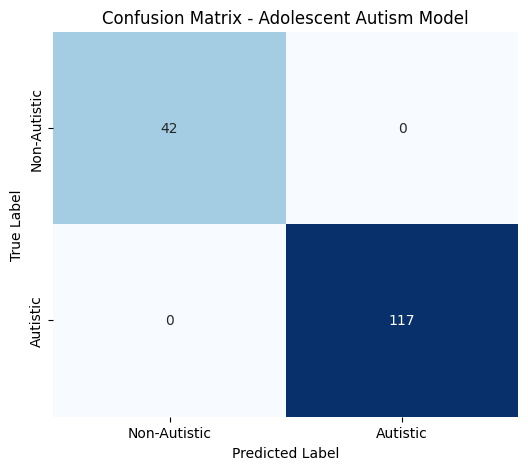

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Threshold at 0.5

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Autistic', 'Autistic'],
            yticklabels=['Non-Autistic', 'Autistic'])
plt.title('Confusion Matrix - Adolescent Autism Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save to Drive
plt.savefig('/content/drive/MyDrive/FYP/adolescent_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
